In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
!pip install mediapipe
import mediapipe as mp
import os
import json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
input_json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json_inputs/'

all_input_json_files = os.listdir(input_json_path)

input_json_data = {}
with open(input_json_path + all_input_json_files[40], 'r') as file:
    s_data = json.load(file)
    input_json_data = {**input_json_data, **s_data}

In [ ]:
calibration_points = [[10, 50], [10, 10], [90, 10], [50, 90],
                   [30, 70], [50, 50], [50, 10], [90, 90],
                   [70, 70], [70, 30], [10, 90], [90, 50],
                   [30, 30]]

In [ ]:
train_y = []

for subject in input_json_data:
    for y in input_json_data[subject]['y']:
        i = 0
        while i < 13:
            zero_vector = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
            zero_vector[i] = 1
            train_y.append(zero_vector)
            i += 1

print(len(train_y))
#print(train_y)

1170


In [ ]:
train_x = []

for subject in input_json_data:
    for sample in input_json_data[subject]['x']:
        calibration_arr = []
        i = 0
        while (i < 13):
            total_arr = []
            head_pose = np.array(sample[i][0])
            iris_points = np.array(sample[i][1])
            head_pose = head_pose.flatten()
            iris_points = iris_points.flatten()
            for element in head_pose:
                total_arr.append(element)
            for element in iris_points:
                total_arr.append(element)
            calibration_arr.append(total_arr)
            i += 1
        #train_x.append(calibration_arr[0])
        for element in calibration_arr:
            train_x.append(element)

In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(1170, 22)
(1170, 13)


In [ ]:
train_y[13]

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
train_x = np.array(train_x)
mean = train_x.mean(axis=0)
train_x -= mean
std = train_x.std(axis=0)
train_x /= std
train_y = np.array(train_y)

In [ ]:
from sklearn.utils import shuffle

train_x, train_y = shuffle(train_x, train_y)

In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(1170, 22)
(1170, 13)


In [ ]:
val_y = train_y[:300]
train_y = train_y[300:]
val_x = train_x[:300]
train_x = train_x[300:]

In [ ]:
print(np.shape(val_x))
print(np.shape(val_y))

(300, 22)
(300, 13)


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.Dense(128, activation="relu"), layers.Dense(64, activation="relu"), layers.Dense(16, activation="relu"), layers.Dense(13, activation="softmax")])
model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_x, train_y, epochs=70, batch_size=40000, validation_data=(val_x, val_y))

Epoch 1/70
1/1 [==============================] - 2s 2s/step - loss: 2.6449 - accuracy: 0.0046 - val_loss: 2.0897 - val_accuracy: 0.2633
Epoch 2/70
1/1 [==============================] - 0s 36ms/step - loss: 2.1285 - accuracy: 0.2138 - val_loss: 1.6899 - val_accuracy: 0.3567
Epoch 3/70
1/1 [==============================] - 0s 41ms/step - loss: 1.7266 - accuracy: 0.2954 - val_loss: 1.8342 - val_accuracy: 0.3833
Epoch 4/70
1/1 [==============================] - 0s 41ms/step - loss: 1.8069 - accuracy: 0.4103 - val_loss: 1.9160 - val_accuracy: 0.3233
Epoch 5/70
1/1 [==============================] - 0s 38ms/step - loss: 1.7583 - accuracy: 0.3575 - val_loss: 1.3685 - val_accuracy: 0.5367
Epoch 6/70
1/1 [==============================] - 0s 34ms/step - loss: 1.3588 - accuracy: 0.5218 - val_loss: 1.3825 - val_accuracy: 0.6000
Epoch 7/70
1/1 [==============================] - 0s 39ms/step - loss: 1.3133 - accuracy: 0.6299 - val_loss: 1.4368 - val_accuracy: 0.4800
Epoch 8/70
1/1 [=============

In [ ]:
print(model.predict(train_x)[0])
print(train_y[0])

28/28 [==============================] - 0s 3ms/step
[3.0730492e-03 1.3437615e-03 5.1288646e-07 2.2118840e-07 4.5830213e-05
 2.5861584e-02 4.2170035e-12 1.1148371e-06 6.0517812e-07 8.9521528e-09
 6.3039060e-04 9.6904302e-01 4.3653383e-08]
[0 0 0 0 0 0 0 0 0 0 0 1 0]


In [ ]:
print(model.predict(val_x)[0])
print(val_y[0])

10/10 [==============================] - 0s 3ms/step
[2.9380200e-04 7.7426614e-11 2.3933493e-08 4.6150936e-04 3.2886076e-11
 1.9248688e-11 2.8308082e-14 5.8104420e-12 9.9774376e-02 1.3389136e-06
 8.6409145e-04 4.0208247e-06 8.9860082e-01]
[0 0 0 0 0 0 0 0 0 0 0 0 1]


In [ ]:
test_point_x = []

for subject in input_json_data:
    for sample in input_json_data[subject]['x']:
        calibration_arr = []
        i = 0
        while (i <= 13):
            if (i == 13):
                total_arr = []
                head_pose = np.array(sample[i][0])
                iris_points = np.array(sample[i][1])
                head_pose = head_pose.flatten()
                iris_points = iris_points.flatten()
                for element in head_pose:
                    total_arr.append(element)
                for element in iris_points:
                    total_arr.append(element)
                calibration_arr.append(total_arr)
            i += 1
        #train_x.append(calibration_arr[0])
        for element in calibration_arr:
            test_point_x.append(element)

In [ ]:
test_point_y = []

for subject in input_json_data:
    for y in input_json_data[subject]['y']:
        test_point_y.append(y)

In [ ]:
train_x = (model.predict(test_point_x)).tolist()

train_y = test_point_y

val_x = train_x[:45]
train_x = train_x[45:]
val_y = train_y[:45]
train_y = train_y[45:]

3/3 [==============================] - 0s 8ms/step


In [ ]:
val_x = np.array(val_x)
mean = val_x.mean(axis=0)
val_x -= mean
std = val_x.std(axis=0)
val_x /= std
val_y = np.array(val_y)

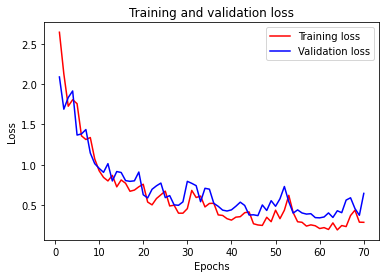

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "r", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

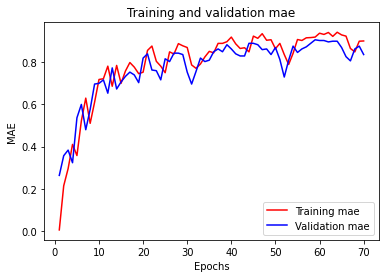

In [ ]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "r", label="Training mae")
plt.plot(epochs, val_acc, "b", label="Validation mae")
plt.title("Training and validation mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
reg_model = keras.Sequential([layers.Dense(128, activation="relu"), layers.Dense(64, activation="relu"), layers.Dense(16, activation="relu"), layers.Dense(2, activation="relu")])
reg_model.compile(optimizer=keras.optimizers.RMSprop(1e-2), loss="MeanSquaredError", metrics=["mae"])

history = reg_model.fit(train_x, train_y, epochs=70, batch_size=40000, validation_data=(val_x, val_y))

Epoch 1/70
1/1 [==============================] - 1s 826ms/step - loss: 3017.1331 - mae: 49.6518 - val_loss: 3521.1938 - val_mae: 53.3135
Epoch 2/70
1/1 [==============================] - 0s 31ms/step - loss: 3003.6292 - mae: 49.5051 - val_loss: 3455.6875 - val_mae: 52.7041
Epoch 3/70
1/1 [==============================] - 0s 32ms/step - loss: 2963.9978 - mae: 49.0827 - val_loss: 3240.7861 - val_mae: 50.5805
Epoch 4/70
1/1 [==============================] - 0s 33ms/step - loss: 2848.6243 - mae: 47.8891 - val_loss: 2897.3701 - val_mae: 46.5501
Epoch 5/70
1/1 [==============================] - 0s 37ms/step - loss: 2652.1143 - mae: 45.7569 - val_loss: 2548.1624 - val_mae: 42.1596
Epoch 6/70
1/1 [==============================] - 0s 31ms/step - loss: 2356.4932 - mae: 42.4333 - val_loss: 2611.4675 - val_mae: 42.9854
Epoch 7/70
1/1 [==============================] - 0s 31ms/step - loss: 1965.3605 - mae: 37.8432 - val_loss: 3922.4084 - val_mae: 54.5316
Epoch 8/70
1/1 [========================

2/2 [==============================] - 0s 8ms/step


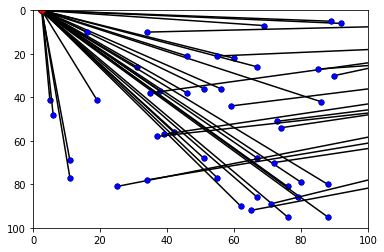

In [ ]:
plt.xlim(0, 100)
plt.ylim(100, 0)
x2 = []
y2 = []
sample_num = 0
while sample_num < 45:
    x = [val_y[sample_num][0]]
    x2 = [(val_y[sample_num][0])]
    x.append(reg_model.predict(val_x)[sample_num][0])
    x3 = [reg_model.predict(val_x)[sample_num][0]]
    y = [val_y[sample_num][1]]
    y2 = [(val_y[sample_num][1])]
    y.append(reg_model.predict(val_x)[sample_num][1])
    y3 = [reg_model.predict(val_x)[sample_num][1]]
    plt.plot(x, y, color="black", marker="o", markersize=5)
    plt.plot(x3, y3, color="red", marker="o", markersize=5)
    plt.plot(x2, y2, color="blue", marker="o", markersize=5)
    sample_num += 1